In [ ]:
# ! pip install --user --upgrade scipy numba
# ! pip install --user psutil

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from trees import TransferTreeRegressor, build_tree, Node
from criteria import mse, transfer, causal_tree_criterion
from sklearn.preprocessing import PolynomialFeatures
from joblib import Parallel, delayed
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 3]

In [3]:
def plot_dat(vars_):
    f, axes = plt.subplots(len(vars_), 1, sharex=True, figsize=(20, 10))

    for (H,title),ax in zip(vars_, axes):
        for i,h in zip(['A', 'B', 'C', 'D'], H):
            sns.distplot(h, label = i, ax=ax)
        ax.legend()
        ax.set_title(title)
        
    # plt.title(title)
    # plt.show()


In [4]:
import numpy as np
from scipy.stats import gamma
import seaborn as sns
from copy import deepcopy

# Y := f(H, W, X, Z, N_Y)
# Y := f(W, X, Z, N_Y)
def fn(h, v, z, w):
    val = -w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0])
    return val


def generate_data(N, fn, hidden_cause, plot, hiddens, v_conds, z_conds):
    # H is latent variable, distribution changes (not )
    H = [np.random.normal(loc=a, scale=b, size=N) for a,b in hiddens]

    # V := f(H, N_X)
    V = [c*h + np.random.normal(loc=a, scale=b, size=N) for h,(c,a,b) in zip(H, v_conds)]

    # if hidden_cause: 
    # H -> V, H -> Y
    # else:
    # V -> H, H -> Y
    if not hidden_cause:
        V,H = deepcopy(H), deepcopy(V)

    # Z = [gamma.rvs(int(np.random.normal(40, 10)), loc=0, scale=1, size=N) for h in H]
    # Z := f(N_Z) 
    Z = [np.random.normal(loc=a, scale=b, size=N) for h,(a,b) in zip(H, z_conds)]

    # W := f(N_W) -- TREATMENT
    W = [np.random.binomial(1, 0.5, size=N) for h in H]

    # Y:= fn(H, V, Z, W, N_Y)
    Y = [fn(H[idx], V[idx], Z[idx], W[idx]) for idx in range(4)]

    taus = [fn(h,v,z,1) - fn(h,v,z,0) for h,v,z in zip(H,V,Z)]
    
    if plot:
        plot_dat([(H,'H'), (V, 'V') , (Z, 'Z'), (Y, 'Y'), (taus, 'tau')])

    return [(y, np.array([w,v,z]).T, tau) for y,v,z,w,h,tau in zip(Y, V, Z, W, H, taus)]

In [5]:
from trees import Leaf
leaf = Leaf(0,0,0,0)

def plot_split(node, X, tau, context_idxs):
    idx = X[:, node.dim] > node.thresh
    d = np.vstack([tau, idx, context_idxs]).T
    df = pd.DataFrame(d, columns = ['tau', 'split', 'ctx'])

    for _, d in df.groupby('split'):
        v = d.groupby('ctx').mean().tau.values
        print(d.groupby('ctx').mean().tau.values)
    # sns.distplot(df)
    g = sns.FacetGrid(df, row = 'split', hue = 'ctx', aspect=5.0)
    g.map(sns.distplot, 'tau', bins=10, kde=False)
    plt.legend()

In [6]:
from sklearn.metrics import mean_squared_error
from numba import njit

def flatten(a):
    return np.array([y for x in a for y in x])


def split_out_dat(dat):
    phi = PolynomialFeatures(degree=1, include_bias=False).fit_transform
    ys, Xs, taus = zip(*dat)

    ys_source, Xs_source = np.concatenate(ys[:-1]), np.concatenate(Xs[:-1])
    ys_target, Xs_target = ys[-1], Xs[-1]

    phi_source = phi(Xs_source[:, 1:])
    phi_target = phi(Xs_target[:, 1:])

    treatment = Xs_source[:, 0]
    N = ys[0].shape[0]

    context_idxs = np.array([j for i,_ in enumerate(ys[:-1]) for j in [i]*N])

    idx = np.arange(phi_source.shape[0])
    np.random.shuffle(idx)

    # print(phi_source.shape)
    # print(ys_source.shape)
    # print(treatment.shape)
    # print(context_idxs.shape)

    phi_source = phi_source[idx, :]
    ys_source = ys_source[idx]
    treatment = treatment[idx]
    context_idxs = context_idxs[idx]
    taus_source, taus_target = flatten(taus[:-1])[idx], taus[-1]

    return phi_source, phi_target, ys_source, treatment, context_idxs, taus_source, taus_target

def fit_models(phi_source, phi_target, ys_source, treatment, context_idxs, taus_source, taus_target):
    causal_model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              max_depth = 3, 
                              min_samples_leaf = 10, 
                              honest= True, 
                              alpha = 0.0)

    causal_model.fit(phi_source, 
                     ys_source, 
                     treatment=treatment,
                     min_samples=25,
                     var_weight=0.5)

    # causal_model.set_best_tree()
    causal_model.tree = causal_model.tree_path[0][1]

    transfer_model = TransferTreeRegressor(criterion = transfer,
                              max_depth = 3, 
                              min_samples_leaf = 10, 
                              honest= True, 
                              alpha = 0.0)

    transfer_model.fit(phi_source, 
                       ys_source, 
                       treatment=treatment,
                       context_idxs=context_idxs, 
                       target_X=phi_target,
                       min_samples=25,
                       mean_weight=0.,
                       var_weight=0.0,
                       tau_var_weight=0.0,
                       cross_exp_weight=1.0,
                       importance=False)

    # transfer_model.set_best_tree()
    # transfer_model.tree
    transfer_model.tree = transfer_model.tree_path[0][1]

    tpreds = transfer_model.predict(phi_target, 0.95)
    cpreds = causal_model.predict(phi_target, 0.95)

    return (mean_squared_error(taus_target, tpreds[:, 0]), mean_squared_error(taus_target, cpreds[:, 0])), (tpreds, cpreds), (transfer_model, causal_model), (phi_source, phi_target, taus_source, taus_target, context_idxs)
    

In [7]:

v_conds = [(-0.5,0,1), (1,1,.5), (0.5,2,1), (-1,2,1)]
# v_conds = [(0.5,0,1)]*4

hiddens = [(0,2)]*4
# hiddens = [(0, 2), (2, 1), (3, 2), (4, 1)]

z_conds = [(2,2), (4,2), (6,2), (0,2)]
# z_conds = [(2,2), (4,2), (6,2), (2,2)]


def runrun(N):
    dat = generate_data(N,
                        fn, 
                        hidden_cause = True, 
                        plot = False, 
                        hiddens = hiddens,
                        v_conds = v_conds, 
                        z_conds = z_conds)

    return fit_models(*split_out_dat(dat))

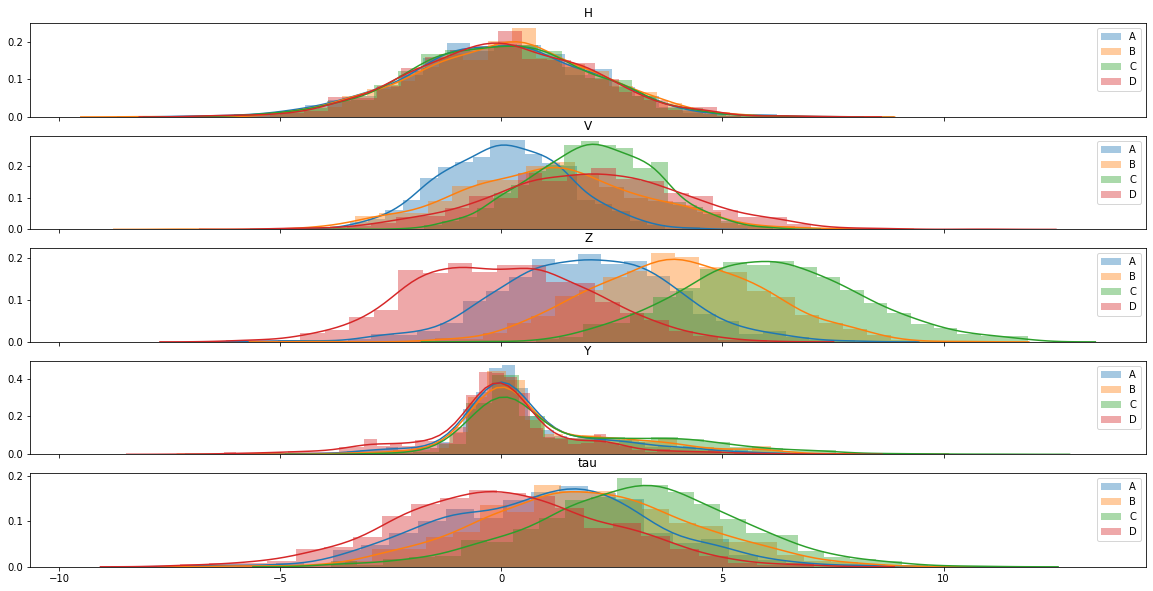

In [8]:
dat = generate_data(1000,
                    fn, 
                    hidden_cause = True, 
                    plot = True, 
                    hiddens = hiddens,
                    v_conds = v_conds, 
                    z_conds = z_conds)


In [9]:
ys, Xs, taus = zip(*dat)
phi_source, phi_target, _, _, _, taus_source, taus_target = split_out_dat(dat)

from sklearn.linear_model import LinearRegression

# LinearRegression().fit(Xs[0], ys[0]).coef_, LinearRegression().fit(Xs[1], ys[1]).coef_, LinearRegression().fit(Xs[2], ys[2]).coef_, LinearRegression().fit(Xs[3], ys[3]).coef_

for d in [LinearRegression().fit(Xs[i], taus[i]).coef_ for i in range(4)]:
    print(d)

[0.00328665 1.09736964 0.4980558 ]
[-0.05045754 -0.9666396   0.47921076]
[-0.00692362 -0.97554977  0.5105086 ]
[-0.07554606  0.82803225  0.50251393]


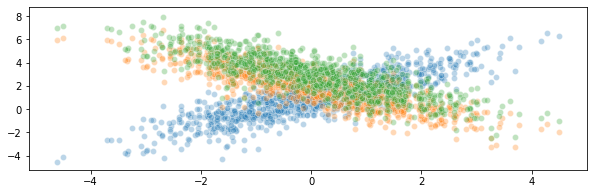

In [10]:
for d in [LinearRegression(fit_intercept=True).fit(Xs[i][:, 1:3], taus[i]).predict(Xs[0][:, 1:3]) for i in range(3)]:
    sns.scatterplot(Xs[0][:, 1], d, alpha=0.3)

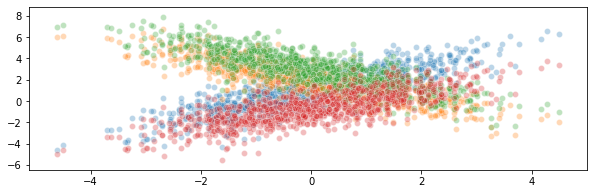

In [11]:
for d in [LinearRegression(fit_intercept=True).fit(Xs[i][:, 1:3], taus[i]).predict(Xs[0][:, 1:3]) for i in range(4)]:
    sns.scatterplot(Xs[0][:, 1], d, alpha=0.3)

In [12]:
scores, preds, models, datt = runrun(1000)
tt, ct = models

In [13]:
tt.tree

|--dim: 1, thresh: 3.0092 scores: -1.254 || 3.430 || 0.018 || 0.920 || 2.507, gain: 0.9041, tot_gain: 1.4099 
   |--dim: 1, thresh: -0.1387 scores: -0.043 || 0.298 || 0.031 || 0.076 || 0.228, gain: -0.0145, tot_gain: -0.0129 
      |--pred: -0.3800, scores: 0.063 || 0.144 || 0.197 || 0.574 || -2.265, N: 84 
      |--dim: 1, thresh: 2.3385 scores: -0.092 || 0.600 || 0.034 || 0.012 || 0.576, gain: 0.0016, tot_gain: 0.0016 
         |--pred: 0.5817, scores: -0.034 || 0.338 || 0.045 || 0.030 || 0.311, N: 327 
         |--pred: 1.1881, scores: -0.059 || 1.411 || 0.128 || 0.081 || 1.188, N: 150 
   |--dim: 0, thresh: 4.0007 scores: -2.115 || 7.204 || 0.027 || 0.348 || 6.757, gain: 0.1239, tot_gain: 0.5187 
      |--dim: 1, thresh: 5.8287 scores: -2.280 || 8.367 || 0.027 || 0.377 || 7.819, gain: 0.3947, tot_gain: 0.3947 
         |--pred: 2.1751, scores: -0.831 || 4.731 || 0.035 || 0.090 || 4.619, N: 540 
         |--pred: 4.1353, scores: -1.844 || 17.100 || 0.067 || 0.129 || 16.511, N: 335 


In [14]:
ct.tree

|--dim: 1, thresh: 3.2254 scores: -1.706 || 3.430 || 0.018, gain: 0.6044, tot_gain: 1.3342 
   |--dim: 1, thresh: -0.1387 scores: -0.055 || 0.300 || 0.029, gain: 0.0400, tot_gain: 0.1187 
      |--pred: -0.3800, scores: 0.001 || 0.144 || 0.197, N: 84 
      |--dim: 0, thresh: 2.7029 scores: -0.096 || 0.585 || 0.032, gain: 0.0787, tot_gain: 0.0787 
         |--pred: 0.9948, scores: -0.150 || 0.990 || 0.033, N: 470 
         |--pred: -1.2867, scores: -0.025 || 1.656 || 0.235, N: 53 
   |--dim: 0, thresh: 2.5515 scores: -2.256 || 7.606 || 0.028, gain: 0.3302, tot_gain: 0.6111 
      |--dim: 1, thresh: 7.1483 scores: -2.495 || 11.821 || 0.032, gain: 0.2496, tot_gain: 0.2496 
         |--pred: 3.0403, scores: -1.572 || 9.243 || 0.034, N: 512 
         |--pred: 5.3615, scores: -1.173 || 28.746 || 0.130, N: 123 
      |--dim: 0, thresh: 4.0007 scores: -0.090 || 1.129 || 0.077, gain: 0.0314, tot_gain: 0.0314 
         |--pred: 1.4416, scores: -0.129 || 2.078 || 0.089, N: 194 
         |--pred:

In [15]:
# dim 0 should be ignored!

imp = lambda tt,ct: tt.feature_importance(gain=False)[1] - ct.feature_importance(gain=False)[1]

imp(tt, ct)

0.05331909194786644

In [16]:
ts, cs = scores
(ts - cs)/cs

-0.33402625305534095

0.17107097639845448
-0.14914306533489635
CPU times: user 3.6 s, sys: 139 ms, total: 3.74 s
Wall time: 2min 18s


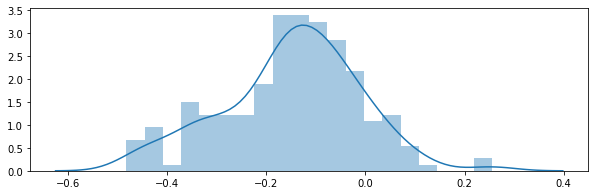

In [23]:
%%time
# N = 1000
# 0.18, -0.16
imp = lambda tt,ct: tt.feature_importance(gain=False)[1] - ct.feature_importance(gain=False)[1]

results = Parallel(n_jobs=-1)(delayed(runrun)(1000) for i in range(200))
mse = [(t-c)/c for (t,c),_,(tt, ct),_ in results]
importances = [imp(tt, ct) for (t,c),_,(tt, ct),_ in results]
print(np.mean(importances))
print(np.mean(mse))
sns.distplot(np.array(mse), bins = 20)

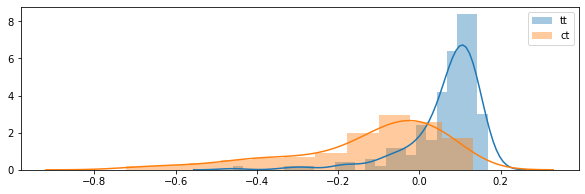

In [24]:
tau_var = [np.mean((np.mean(txx) - txx)**2) for _,_,_,(_,_,_,txx,_) in results]
t_mse, c_mse = zip(*[(t,c) for (t,c),_,(tt, ct),_ in results])
for lbl,d in zip(['tt', 'ct'], [[1-a/b for a,b in zip(t_mse, tau_var)], [1-a/b for a,b in zip(c_mse, tau_var)]]):
    sns.distplot(d, label=lbl)
plt.legend()

In [25]:
# 0.06, -0.14

np.mean(np.array([[1-a/b for a,b in zip(t_mse, tau_var)], [1-a/b for a,b in zip(c_mse, tau_var)]]), 1)

array([ 0.06400929, -0.12509985])

In [26]:
def compare_cis(results):
    taus = [txx for _,_,_,(_,_,_,txx,_) in results]
    tp, cp = zip(*[preds for _,preds,_,_ in results])

    tis = [get_within_ci(d,t) for d,t in zip(tp, taus)]
    cps = [get_within_ci(d,t) for d,t in zip(cp, taus)]

    return tis, cps


def get_within_ci(preds, taus):
    return pd.DataFrame(preds, columns = ['pred', 'lower', 'upper']) \
             .assign(true = taus) \
             .groupby('pred') \
             .apply(lambda df: df.assign(true_cate = df.true.mean())) \
             .pipe(lambda df: df.assign(within_int = (df.true_cate <= df.upper) & (df.true_cate >= df.lower))) \
             .pipe(lambda df: df['within_int'].sum() / df.shape[0])

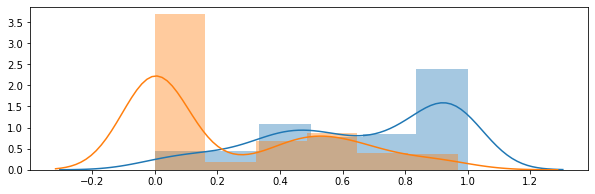

In [27]:
for a in compare_cis(results):
    sns.distplot(a)

In [28]:
# .68, 0.20

np.mean(compare_cis(results)[0]), np.mean(compare_cis(results)[1])

(0.65495, 0.23595500000000003)

# Causal Tree Test

In [18]:
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

def make_nested_grid(params):
    return ParameterGrid({ key: list(ParameterGrid(value))
                           for key, value in params.items()})


def _crossval_score(model, X, y, treatment, weights, splitter, fit_params, init_params):
    model = deepcopy(model)
    model.set_params(**init_params)
    scores = []

    for train_idx, test_idx in splitter.split(X, treatment):
        model.fit(X[train_idx, :], 
                  y[train_idx], 
                  treatment = treatment[train_idx], 
                  sample_weight = weights[train_idx],
                  **fit_params)

        score = model.score(X[test_idx, :],
                            y[test_idx], 
                            treatment = treatment[test_idx], 
                            sample_weight = weights[test_idx],
                            **fit_params)
            
        scores.append(score)
    
    return np.mean(scores)

from joblib import Parallel, delayed

def model_search(model, X, y, treatment, weights, init_params, fit_params, splitter, n_jobs = -1):
    grid = make_nested_grid({'fit_params': fit_params, 
                             'init_params': init_params})

    all_scores = Parallel(n_jobs=n_jobs)(delayed(_crossval_score)(model, X, y, treatment, weights, splitter, **g) for g in grid)
    # all_scores = [_crossval_score(model, X, y, treatment, weights, splitter, **g) for g in grid]

    return list(zip(grid, all_scores))   

In [20]:
def eta(X):
    return 0.5 * X[:, 0] + X[:, 1]

def kappa(X):
    return 0.5 * X[:, 0]

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01)

N = 1000
S = round(N/2)
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
y = gen_y(X, treatment)

In [48]:
def eta(X):
    return 0.5 * np.sum(X[:, :2], axis=1) + np.sum(X[:, 2:], axis=1)

def kappa(X):
    return np.sum(X[:, :2] * (X[:, :2] > 0).astype(int), axis=1)

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01, size = X.shape[0])


N = 12000
S = 1000
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
weights = np.ones(N)
y = gen_y(X, treatment)

In [49]:
sim_dat = pd.concat([pd.DataFrame(X, columns = range(1, 7)), 
                     pd.DataFrame({ 'y': y, 'treatment': treatment, 'tau': kappa(X)})], axis=1)

sim_dat.to_csv('sim_dat-2.csv', index=False)

In [43]:
# idx = np.arange(X.shape[0])
# np.random.shuffle(idx)

# treatment = treatment[idx]
# X = X[idx, :]
# y = y[idx]

In [50]:
%%time

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 3)

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 4,
                              alpha = 0.1, 
                              honest = False)

fit_params = {'min_samples': [25] }
init_params = {'alpha': [ -.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.4 ], 'honest': [True] }

results = model_search(model, X[:S], y[:S], treatment[:S], weights[:S], init_params, fit_params, cv)

best_params = sorted(results, key = lambda t: t[1])[0][0]['init_params']

best_params

CPU times: user 23.8 ms, sys: 8.13 ms, total: 31.9 ms
Wall time: 378 ms


{'alpha': 0.0, 'honest': True}

In [56]:
from sklearn.metrics import r2_score

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 50,
                              alpha = 0.1, 
                              honest = False)

# model.set_params(**best_params)
model.set_params(alpha = -100.0, honest=True)

model.fit(X[:S], y[:S], treatment=treatment[:S], min_samples=25, var_weight = 0.5)

print(r2_score(kappa(X[S:]), model.predict(X[S:])))

model.tree

0.25306848861537323


|--dim: 1, thresh: 0.3194 scores: -0.422 || 0.931 || 0.087, gain: 0.1567, tot_gain: 0.1760 
   |--dim: 0, thresh: -0.3486 scores: -0.006 || 0.163 || 0.144, gain: 0.0530, tot_gain: 0.0080 
      |--pred: -0.2550, scores: 0.029 || 0.065 || 0.348, N: 103 
      |--dim: 4, thresh: 0.0986 scores: -0.088 || 0.651 || 0.209, gain: -0.0451, tot_gain: -0.0451 
         |--pred: 0.9389, scores: -0.058 || 0.881 || 0.291, N: 99 
         |--pred: 0.4186, scores: 0.016 || 0.175 || 0.332, N: 100 
   |--dim: 4, thresh: 0.3878 scores: -0.573 || 3.090 || 0.197, gain: 0.0320, tot_gain: 0.0113 
      |--dim: 3, thresh: 0.0808 scores: -0.432 || 3.489 || 0.266, gain: -0.0207, tot_gain: -0.0207 
         |--pred: 1.8345, scores: -0.224 || 3.365 || 0.452, N: 77 
         |--pred: 1.9028, scores: -0.187 || 3.621 || 0.344, N: 57 
      |--pred: 1.7472, scores: -0.173 || 3.053 || 0.350, N: 64 

In [28]:
preds = pd.DataFrame(model.predict(X[S:], interval = 0.975), columns = ['pred', 'lower', 'upper'])

preds.assign(true = kappa(X[S:])) \
    .groupby('pred') \
    .apply(lambda df: df.assign(true_cate = df.true.mean())) \
    .pipe(lambda df: df.assign(within_int = (df.true_cate <= df.upper) & (df.true_cate >= df.lower))) \
    .pipe(lambda df: df['within_int'].sum() / df.shape[0])

0.7431

In [ ]:
model = TransferTreeRegressor(criterion = mse, max_depth = 5, min_samples_leaf = 10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
# np.mean((preds - y)**2)

np.histogram(preds)

In [60]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
np.mean((preds - y)**2)

(array([  15,    0,   41,   23,   95,   47,   87,  103,  406, 1183]),
 array([-129.40835129, -116.21549089, -103.02263049,  -89.82977009,
         -76.63690969,  -63.44404929,  -50.25118889,  -37.05832849,
         -23.86546809,  -10.67260769,    2.52025272]))

In [34]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [35]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [36]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.7473, 32.487 , 11.613 ,  4.5725])

In [37]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([12.42759, 25.75614,  5.67631,  3.50874])

In [38]:
model = TransferTreeRegressor(criterion=mse, max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [39]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [52]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.3818, 32.1958, 11.2033,  3.5604])

In [51]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([10.9098,  4.9235,  3.2745,  3.7268])

In [42]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 1, use_weights = None, model_search = False)

[0.3605, 21.2762, 16.201, 7.1304]

In [31]:
run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True)

[0.4141, 20.8479, 0.2354, 6.2956]

In [32]:
run_model(dat, model, phi, 0, 1, use_weights = 1, model_search = False)

[12.3876, 41.752, 16.8672, 4.4122]

In [33]:
run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True)

[11.362, 31.8239, 11.2857, 4.7136]

In [1802]:
# get residuals for "sets" separately
# compute distance between residuals
# optimize squared errors + penalty for residual distance

# search for "sets" by looking at residuals and fitting a mixture model
# then optimize to remove that mixture...

# set up an adversarial problem: the adversary tries to find a 
# mixture model in your reiduals, the classifier tries to make force the
# adversary to fit a 1-component mixture, for example... 